# Galaxies

### Load Galaxy Catalog

In [6]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/")

In [7]:
import numpy as np
from libs.main import copacabana
from libs.make_input_files.make_input_datasets import make_master_file

import h5py
import matplotlib.pyplot as plt

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


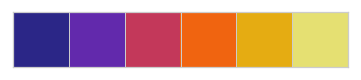

In [8]:
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("CMRmap"))

In [9]:
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

In [11]:
cfg = '../libs/config_copa_dc2.yaml'
copa = copacabana(cfg)

def read_file(run_name,old=False):
    if old: run_name += '_old'
    gal   = copa.load_copa_out('members',run=run_name)
    return gal

In [13]:
run = 'emuBPZ-rhod-zw'
gal = read_file(run)

Matching Copa output with main and BMA


In [14]:
run = 'emuBPZ-rhod-zw'
cat   = copa.load_copa_out('cluster',run=run)

In [15]:
gal2 = read_file('emuBPZ-rhod')

Matching Copa output with main and BMA


### Galaxy Selection

In [16]:
## colors
blue = '#2E86C1'
gray = '#A6ACAF'

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_precision_recall_vs_threshold(true_members,scores,title='',c1=blue,c2=gray):
    precisions, recalls, thresholds = precision_recall_curve(true_members, scores)

    ## optimal value
    idx = np.argmax(recalls*precisions)

    recall_opt_precision = recalls[idx]
    precision_opt_precision = precisions[idx]
    threshold_opt_precision = thresholds[idx]

    print("Optimal threshold: %.3f"%threshold_opt_precision)
    print("Optimal recall   : %.3f"%recall_opt_precision)
    print("Optimal precision: %.3f"%precision_opt_precision)

    _plot_precision_recall_vs_threshold(precisions, recalls, thresholds,c1=c1,c2=c2)
    plt.plot([threshold_opt_precision, threshold_opt_precision], [0., recall_opt_precision], "r:")
    plt.plot([0., threshold_opt_precision], [precision_opt_precision, precision_opt_precision], "r:")
    plt.plot([0., threshold_opt_precision], [recall_opt_precision, recall_opt_precision], "r:")
    plt.plot([threshold_opt_precision], [precision_opt_precision], "ro")
    plt.plot([threshold_opt_precision], [recall_opt_precision], "ro",label="Optimal value")
    plt.legend(loc=(1.05,0.8),fontsize=18)
    
    plt.title("%s "%title,fontsize=16)
    #plt.show()

def _plot_precision_recall_vs_threshold(precisions, recalls, thresholds, c1=blue, c2=gray):
    plt.plot(thresholds, precisions[:-1], c1, label="Purity", linewidth=4)
    plt.plot(thresholds, recalls[:-1], c2, label="Completeness", linewidth=4)
    plt.legend(fontsize=16)
    plt.xlabel(r'Threshold: $P_{mem}$', fontsize=20)
    plt.grid(True)                      
    plt.ylim(0.0,1.)
    plt.xlim(-0.01,1.01)
    ticks0 = np.arange(0.,1.01,0.1)
    plt.xticks(ticks0)
    plt.yticks(ticks0)



Optimal threshold: 0.456
Optimal recall   : 0.923
Optimal precision: 0.797


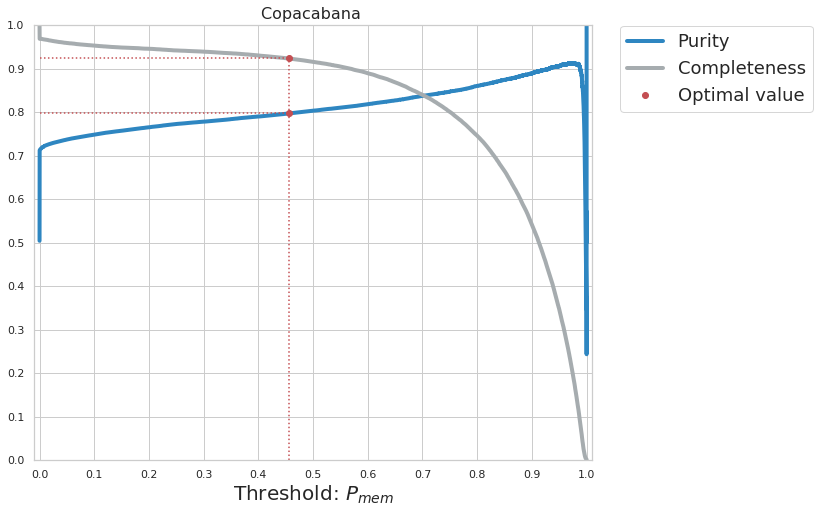

In [18]:
true_members1 = np.where(gal['True'],1.,0.)
scores1      = np.where(np.isnan(gal["Pmem"]),0,gal['Pmem'])
# scores = y_scores_forest
plt.figure(figsize=(10, 8))
plot_precision_recall_vs_threshold(true_members1,scores1,title='Copacabana')

Optimal threshold: 0.502
Optimal recall   : 0.905
Optimal precision: 0.773


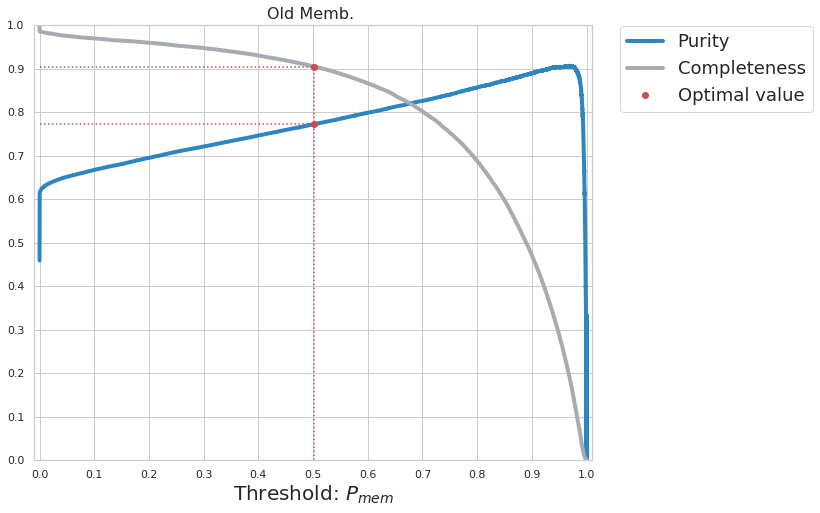

In [19]:
true_members2 = np.where(gal2['True'],1.,0.)
scores2 = np.where(np.isnan(gal2["Pmem"]),0,gal2['Pmem'])
# scores = y_scores_forest
plt.figure(figsize=(10, 8))
plot_precision_recall_vs_threshold(true_members2,scores2,title='Old Memb.')

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_precision_recall(precisions, recalls, color='b', label=None):
    plt.plot(recalls[:-1], precisions[:-1], color=color, label=label, linewidth=2)
    plt.xlabel(r'Completeness', fontsize=20)
    plt.ylabel(r'Purity', fontsize=20)
    plt.grid(True)                      
    plt.ylim(0.0,1.)
    plt.xlim(-0.01,1.01)
    ticks0 = np.arange(0.,1.01,0.1)
    plt.xticks(ticks0)
    plt.yticks(ticks0)
    plt.legend(fontsize=18)

In [21]:
def plot_purity_completeness_curve(scores,true_members,label=None,color='r',save='bla.png'):
    # scores = y_scores_forest

    precisions, recalls, thresholds = precision_recall_curve(true_members, scores)

    ## optimal value
    idx = np.argmax(recalls*precisions)
    
    recall_opt_precision = recalls[idx]
    precision_opt_precision = precisions[idx]
    threshold_opt_precision = thresholds[idx]
    
    y_pred_opt = scores>=threshold_opt_precision
    
    f1score= f1_score(true_members,y_pred_opt)
    
    print('photo-z: %s'%label)
    print("Optimal threshold: %.3f"%threshold_opt_precision)
    print("Optimal recall   : %.3f"%recall_opt_precision)
    print("Optimal precision: %.3f"%precision_opt_precision)
    print("Optimal F1 scoere: %.3f"%f1score)
    print('\n')
    
    label = "%s: P=%.2f,  C=%.2f"%(label,precision_opt_precision,recall_opt_precision)
    plot_precision_recall(precisions, recalls,color=color,label=label)
    plt.plot([recall_opt_precision, recall_opt_precision], [0., precision_opt_precision], "k:")
    plt.plot([0., recall_opt_precision], [precision_opt_precision, precision_opt_precision], "k:")
    plt.plot([recall_opt_precision], [precision_opt_precision], 'ro')
#     plt.legend(fontsize=20)
    # plt.title("Precision, Recall vs Threshold",fontsize=16)
    
    plt.savefig(save)
#     plt.show()

In [22]:
scores = [scores2,scores1]
labels = [true_members2,true_members1]

photo-z: Old membAssignment: $\sigma_0 = 0.03$
Optimal threshold: 0.502
Optimal recall   : 0.905
Optimal precision: 0.773
Optimal F1 scoere: 0.834


photo-z: Copacabana: $\sigma_0 = 0.03$
Optimal threshold: 0.456
Optimal recall   : 0.923
Optimal precision: 0.797
Optimal F1 scoere: 0.856




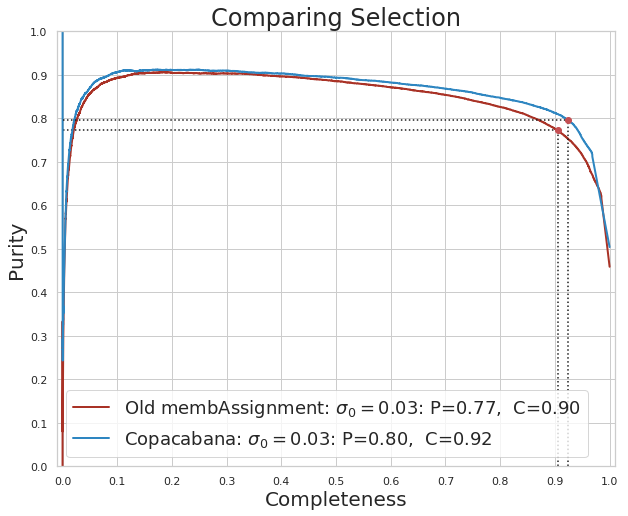

In [23]:
plt.figure(figsize=(10, 8))

red = '#A93226'
colors= [red,blue]
label = [r'Old membAssignment: $\sigma_0 = 0.03$',r'Copacabana: $\sigma_0 = 0.03$']
data  = [gal2,gal]

for i in range(2):
    plot_purity_completeness_curve(scores[i],labels[i],label=label[i],color=colors[i],save='fig_4l_pc_photozs.png')

plt.title('Comparing Selection',fontsize=24)
plt.savefig('fig_comparing_PC_oldMemb_Copa.png')

In [24]:
def plot_histograms(galaxies,prob,axs,xlabel=r'$P_{r}$'):
    mask = galaxies['True'] == True
    nmask = galaxies['True'] == False

    xbins = np.linspace(0.,1.,11)
    
    # axis.hist(prob,bins=xbins,ec='blue', fc='none', lw=1.5, histtype='step',label='All')
    axs.hist(prob[mask],bins=xbins,ec='red', fc='none', lw=1.5, histtype='step',label='True members')
    axs.hist(prob[nmask],bins=xbins,ec='gray', fc='none', lw=1.5, histtype='step',label='Non members')
    
    axs.set_xlabel(r'$P_{%s}$'%xlabel[1:],fontsize=16)
    axs.set_ylabel('N')

def plot_single_histogram(galaxies,prob,lcol,title='Buzzard v1.6'):
        
    fig, ax = plt.subplots(figsize=(6,6))
    plot_histograms(galaxies,prob,ax,xlabel=lcol)
    plt.legend(loc='upper left',fontsize=12)
    fig.suptitle(title,fontsize=16)
    
def plot_grid_histograms(galaxies,title='Buzzard v1.6'):
    fig, axis = plt.subplots(2, 2, figsize=(8,8), sharex='col', sharey='all')

    labels = [['Pr','Pz'],['Pc','Pmem']]
    for i in range(2):
        for j in range(2):
            prob = galaxies[labels[i][j]]
            prob[np.isnan(prob)] = 0.
            plot_histograms(galaxies,prob,axis[i,j],xlabel=labels[i][j])

            if i ==0 and j==0: axis[0,0].legend(loc='upper left',fontsize=12)
    
    axis[0,0].set_xlim(-0.01,1.01)
    axis[0,1].set_xlim(-0.01,1.01)
    fig.suptitle(title,fontsize=16)
    fig.tight_layout()

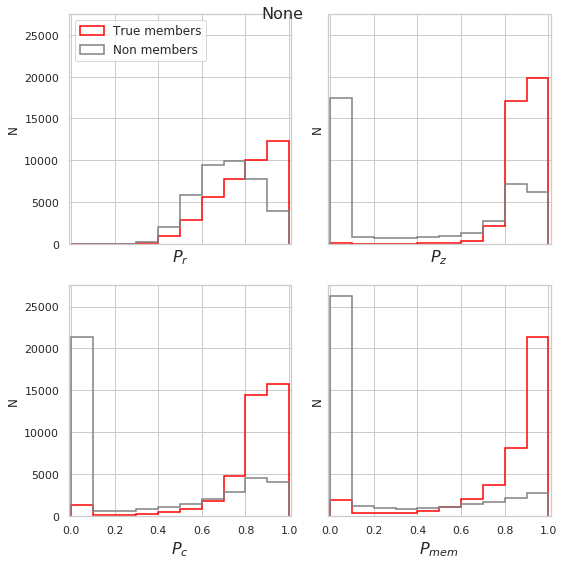

In [25]:
plot_grid_histograms(gal,title=None)
plt.savefig('fig_4e_prob_hist.png')

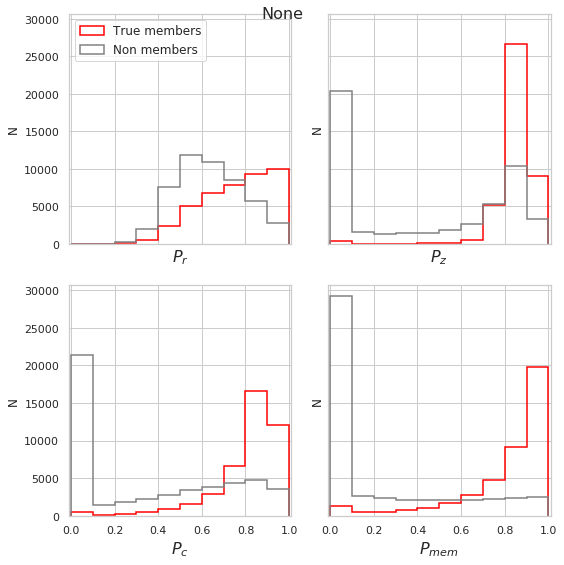

In [26]:
plot_grid_histograms(gal2,title=None)
#plt.savefig('fig_4e_prob_hist.png')

### Mag Evolution

In [27]:
amag = gal['Mr']
mag  = gal['mag']

mass = gal['stellar_mass']

In [28]:
zcls = gal['redshift']

Text(0,0.5,'Mr')

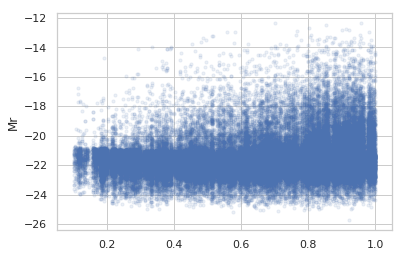

In [36]:
plt.scatter(zcls,amag,s=10,alpha=0.1)
plt.ylabel('Mr')

Text(0,0.5,'stellar_mass')

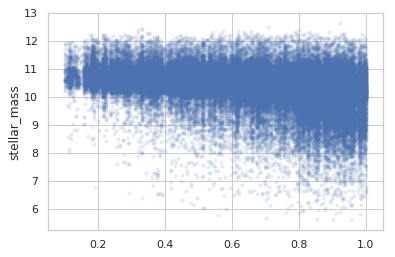

In [35]:
plt.scatter(zcls,np.log10(mass),s=10,alpha=0.1)
plt.ylabel('stellar_mass')